In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_vanderpol(y, t, eps):
    x, y = y
    dxdt = y - (x**3)/3 + x
    dydt = -eps * x
    return [dxdt, dydt]


def slow_vanderpol(y, tau, eps):
    x, y = y
    dxdtau =  (y - (x**3)/3 + x)/eps
    dydtau = - x
    return [dxdtau, dydtau]

def slow_subsystem(y, tau):
    x, y = y
    dxdtau = x / (1 - x ** 2)
    dydtau = - x
    return [dxdtau, dydtau]


# Initial points x, y:
x_init, y_init = 1.0, 1.0
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}")

def equation(x, y):
    return y - (x**3) / 3 + x   #slow (critical) manifold


# Define the range of x values to search within
x_values = np.linspace(0, 4, 1000000)


# for x in x_values:    # Find the smallest x that satisfies the equation
for x in reversed(x_values):    # Find the largest x that satisfies the equation
    if np.abs(equation(x, y_init)) <= 1e-5: 
        print(f"The largest x for y_init = {y_init} is approximately: {x}")
        x_ub = float(x) 
        print('Upper bound for x_slow:',x_ub)
        print('Upper bound for y_slow:',y_init)
        break
        

t_end = 10
t  =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0, -t_end, 100)
eps = 0.1
T_slow_end = 10
tau = np.linspace(0, T_slow_end, 100)

x_real, y_real = odeint(slow_vanderpol, [x_init, y_init], tau, args=(eps,)).T
x_end, y_end = 0.0, -1.0
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}")

t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 10

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
phys_weight = 10
initbnd_weight = 10

def loss_func_fast(model, t_tensor, x_init, y_init,\
                                   x_f_end, y_f_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dx_dt = torch.autograd.grad(x_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast =  dx_dt -  (y_pred_fast - (x_pred_fast**3)/3 + x_pred_fast)
    residual2_fast = (y_pred_fast - y_init) # # dy_dt + eps * x_pred_fast
    #for the fast subsystem
    residual3_fast =  dy_dt 
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init)                 
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2)
    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_f_end) +\
                         torch.square(y_pred_fast[-1] - y_f_end) 
    
    # Penalty to enforce x_pred_slow < x_ub for each component
    penalty_loss_fast = torch.relu(x_pred_fast - x_ub).sum() +\
                        torch.relu(x_init - x_pred_fast).sum()
    
    total_loss_fast   = phys_weight * physics_loss_fast +\
                        initbnd_weight* (init_loss_fast + boundary_loss_fast) +\
                        0.1 * penalty_loss_fast
    return total_loss_fast
def loss_func_fast2(model, t2_tensor, x_end, y_end,\
                                 x_f2_end, y_f2_end, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
                                            
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    # for the fast system
    residual1_fast2 =  dx_dt2 -  (y_pred_fast2 - (x_pred_fast2**3)/3 + x_pred_fast2)
    residual2_fast2 = y_pred_fast2 - y_end # dy_dt2 + eps * x_pred_fast2
    # for the fast subsystem
    residual3_fast2 =  dy_dt2
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2)
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x_f2_end) +\
                          torch.square(y_pred_fast2[-1] - y_f2_end) 
    # Penalty to enforce y_pred_slow > y_end for each component
    #penalty_loss_fast2 = torch.relu(y_pred_fast2 - y_end).sum()
    penalty_loss_fast2 = torch.relu(x_end - x_pred_fast2).sum() +\
                        torch.relu(x_pred_fast2 - 1).sum()
    
    # penalty_loss_fast22 = torch.max(torch.tensor(0.0), x_pred_fast2[-1] + 1.0) ** 2
    total_loss_fast2 = phys_weight * physics_loss_fast2 +\
                       initbnd_weight* (init_loss_fast2 + boundary_loss_fast2) +\
                       0.1 * penalty_loss_fast2 

    return total_loss_fast2

def loss_func_slow(model, tau_tensor, x_1, y_1, x_2, y_2, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    
    # for the slow system
    residual1_slow = dx_dtau - (y_pred_slow - (x_pred_slow**3)/3 + x_pred_slow)/ eps  
    residual2_slow = dy_dtau + x_pred_slow
    # for the slow subsystem
    residual3_slow = 0 # dx_dtau - x_pred_slow/(1 - x_pred_slow**2)
    
    init_loss_slow = torch.square(x_pred_slow[0] - x_1) +\
                     torch.square(y_pred_slow[0] - y_1) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_2) +\
                         torch.square(y_pred_slow[-1] - y_2) 
    
    penalty_loss_crit_manif = ((y_pred_slow - ((x_pred_slow ** 3) / 3 - x_pred_slow)) ** 2).sum()

    # Penalty for violating x constraints
    penalty_slow_x1 = torch.relu(1 - x_pred_slow).sum()
    penalty_slow_x2 = torch.relu(x_pred_slow - x_ub).sum()
    penalty_slow_y1 = torch.relu(-2/3 - y_pred_slow).sum()
    penalty_slow_y2 = torch.relu(y_pred_slow - y_init).sum()
    
    penalty_slow =  penalty_slow_x1 +  penalty_slow_x2 +\
                   penalty_slow_y1 + penalty_slow_y2 
    
    
    total_loss_slow = phys_weight * physics_loss_slow +\
                        initbnd_weight* (init_loss_slow + boundary_loss_slow) +\
                        10 * penalty_loss_crit_manif +\
                        1 * penalty_slow 
                        

    return total_loss_slow


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, x_f_end, y_f_end,\
                    x_1, y_1, x_2, y_2,\
                    x_end, y_end, x_f2_end, y_f2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init,\
                                                   x_f_end, y_f_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end,\
                                                   x_f2_end, y_f2_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               x_1, y_1, x_2, y_2, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss




The initial points of the BVP: x_init = 1.0, y_init = 1.0
The largest x for y_init = 1.0 is approximately: 2.1038061038061038
Upper bound for x_slow: 2.1038061038061038
Upper bound for y_slow: 1.0
The ending points of the BVP: x_end = 0.0, y_end = -1.0


Epoch 0, Total Loss: 537.6715093873487
Epoch 1000, Total Loss: 15.711855179761256
Epoch 2000, Total Loss: 12.475368789895446
Epoch 3000, Total Loss: 10.701995181843428
Epoch 4000, Total Loss: 10.245731906651116
Epoch 5000, Total Loss: 10.133026404712165
Epoch 6000, Total Loss: 10.073158380476446
Epoch 7000, Total Loss: 10.007046851052023
Epoch 8000, Total Loss: 10.08912882107278
Epoch 9000, Total Loss: 9.962844206058413
Epoch 10000, Total Loss: 10.00446792838775
Epoch 11000, Total Loss: 9.923886081941388
Epoch 12000, Total Loss: 9.927363979288641
Epoch 13000, Total Loss: 9.927328267614948
Epoch 14000, Total Loss: 9.901786756474078
Epoch 15000, Total Loss: 9.893809563814507
Epoch 16000, Total Loss: 9.893424817083105
Epoch 17000, Total Loss: 10.026449257100241
Epoch 18000, Total Loss: 9.986388740530007
Epoch 19000, Total Loss: 9.909624697679046
Epoch 20000, Total Loss: 9.890140461817051
Epoch 21000, Total Loss: 9.955695771568605
Epoch 22000, Total Loss: 9.957535834689075
Epoch 23000, Tot

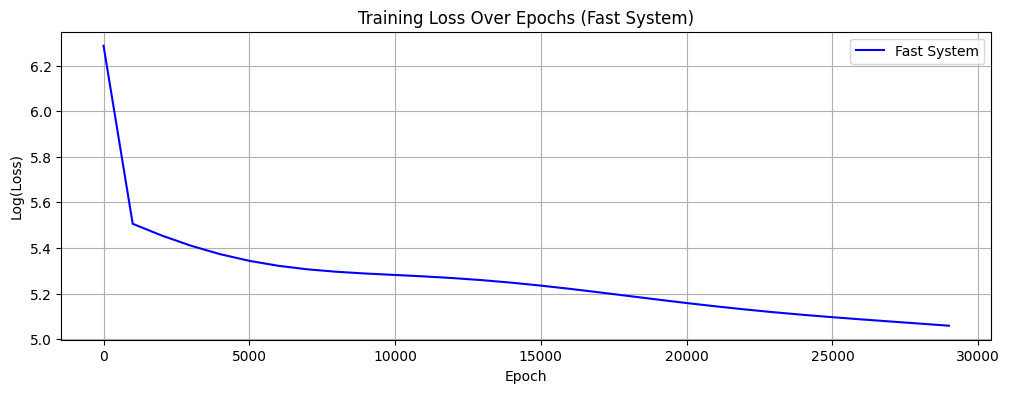

/tmp/ipykernel_198/1042744883.py:84: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_init, y_init, 'go', color='cyan', label='Initial point')


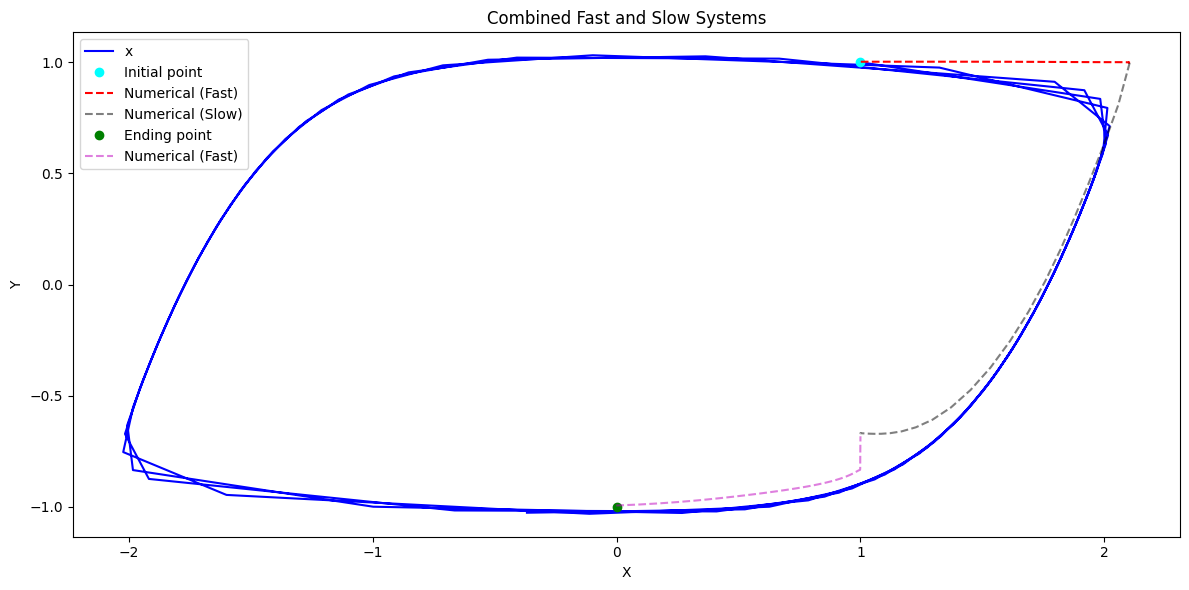

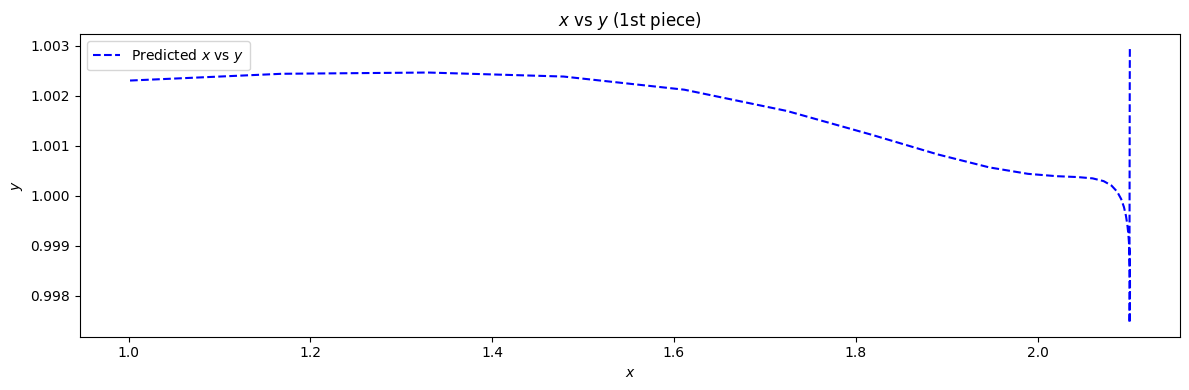

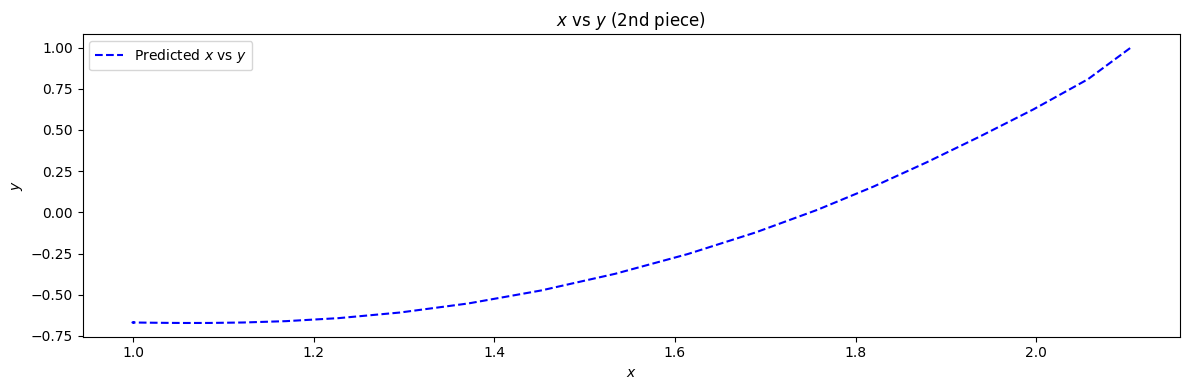

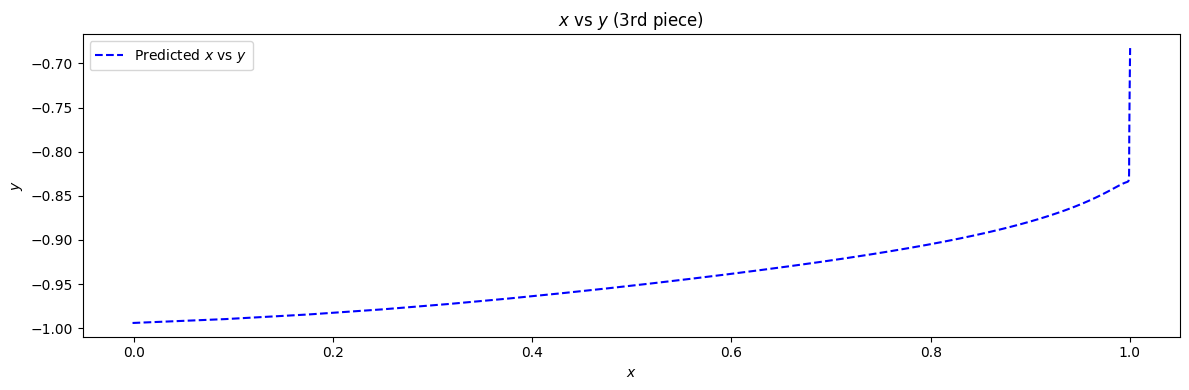

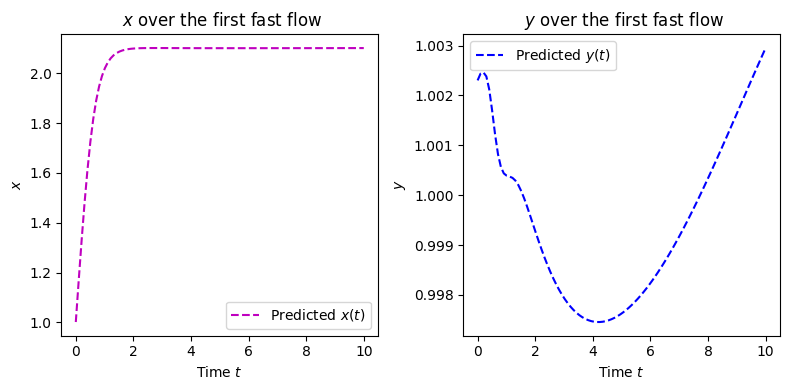

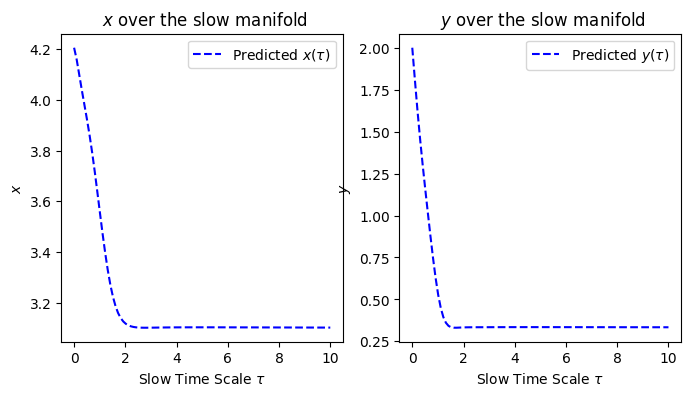

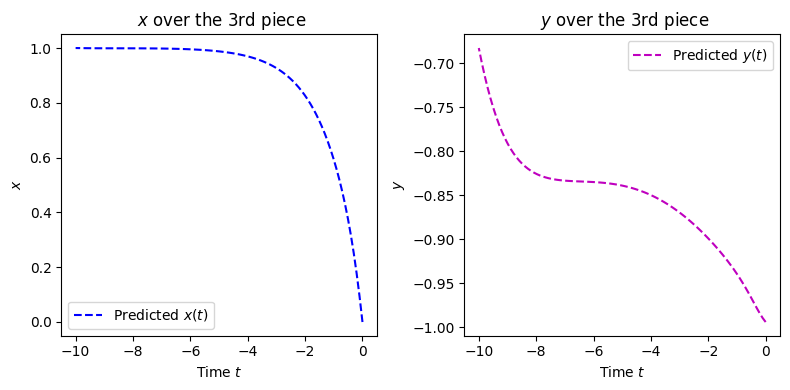

In [32]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 30000


    xf_end, yf_end =  np.random.uniform(1, 3), np.random.uniform(0, 2) #-2, -2 #
    xf2_end, yf2_end =  np.random.uniform(1, 2) , np.random.uniform(-1, 0) #-1, 2 #

    xs_init, ys_init =  np.random.uniform(1, 3), np.random.uniform(0, 2)  # -2, -2 # 
    xs_end, ys_end =  np.random.uniform(1, 2) , np.random.uniform(-1, 0) # -1, 2 #


    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, xf_end, yf_end,\
                                     xs_init, ys_init,\
                                     xs_end, ys_end,\
                                     x_end, y_end, xf2_end, yf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end  = x_pred_slow[0], y_pred_slow[0]
            xs_init, ys_init = x_pred_fast[-1], y_pred_fast[-1]
            xs_end,  ys_end  = x_pred_fast2[-1], y_pred_fast2[-1]
            xf2_end, yf2_end = x_pred_slow[-1],  y_pred_slow[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
            
            #print('xs_init, ys_init are:', f"xs_init = {xs_init}, ys_init = {ys_init}")
            #print('xf_end, yf_end are:', f"xf_end = {xf_end}, yf_end = {yf_end}")
            #print('xs_end, ys_end are:', f"xs_end = {xs_end}, ys_end = {ys_end}")
            #print('xf2_end, yf2_end are:', f"xf2_end = {xf2_end}, yf2_end = {yf2_end}")
            
            
            #print('x_pred_slow:',x_pred_slow[:10])
            #print('y_pred_slow:',y_pred_slow[:10])

        loss_values.append(loss_total.item())
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_fast2.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T
        # Predictions for fast system
        x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
        
    
    # Plotting in 2D
    plt.figure(figsize=(12, 6))

    # Plot initial point
    plt.plot(x_real, y_real, 'b-', label='x')
    plt.plot(x_init, y_init, 'go', color='cyan', label='Initial point')

    # Plot numerical (fast)
    plt.plot(x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

    # Plot numerical (slow)
    plt.plot(x_pred_slow, y_pred_slow, 'k--', label='Numerical (Slow)', alpha=0.5)

    # Plot ending point
    plt.plot(x_end, y_end, 'go', label='Ending point')

    # Plot numerical (fast 2)
    plt.plot(x_pred_fast2, y_pred_fast2, 'm--', label='Numerical (Fast)', alpha=0.5)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Combined Fast and Slow Systems')
    plt.legend()
    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    
    

    
    # Plotting "x" vs "y" over the 1st piece
    plt.figure(figsize=(12, 4))

    plt.plot(x_pred_fast, y_pred_fast, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (1st piece)')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Plotting "x" vs "y" over the 2nd piece
    plt.figure(figsize=(12, 4))

    plt.plot(x_pred_slow, y_pred_slow, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (2nd piece)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting "x" vs "y" over the 3rd piece
    plt.figure(figsize=(12, 4))
    plt.plot(x_pred_fast2, y_pred_fast2, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (3rd piece)')
    plt.legend()


    plt.tight_layout()
    plt.show()
    
     #########1st piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    #plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
    plt.plot(t, x_pred_fast, 'm--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the first fast flow')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
    plt.plot(t, y_pred_fast, 'b--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the first fast flow')
    plt.legend()
    

    plt.tight_layout()
    plt.show()
    
    ########2nd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    #plt.plot(tau, x_exact_slow + x_exact_fast[-1], 'b-', label='Exact $x(t)$')
    plt.plot(tau, x_pred_slow + x_pred_fast[-1], 'b--', label='Predicted $x(\\tau)$')
    plt.xlabel('Slow Time Scale $\\tau$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the slow manifold')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(tau, y_exact_slow + y_exact_fast[-1], 'b-', label='Exact $y(t)$')
    plt.plot(tau, y_pred_slow + y_pred_fast[-1], 'b--', label='Predicted $y(\\tau)$')
    plt.xlabel('Slow Time Scale $\\tau$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the slow manifold')
    plt.legend()
    
    
    ########3rd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    #plt.plot(t2, x_exact_fast2 , 'b-', label='Exact $x(t)$')
    plt.plot(t2, x_pred_fast2 , 'b--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the 3rd piece')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(t2, y_exact_fast2 , 'b-', label='Exact $y(t)$')
    plt.plot(t2, y_pred_fast2 , 'm--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the 3rd piece')
    plt.legend()
    

    plt.tight_layout()
    plt.show()




In [33]:
print("x_pred_fast[0] is:", x_pred_fast[0])
print("y_pred_fast[0] is:", y_pred_fast[0])

print("x_pred_fast[-1] is:", x_pred_fast[-1])
print("y_pred_fast[-1] is:", y_pred_fast[-1])

x_pred_fast[0] is: 1.0015437980442268
y_pred_fast[0] is: 1.002300896236417
x_pred_fast[-1] is: 2.101553112441745
y_pred_fast[-1] is: 1.0029493558001794


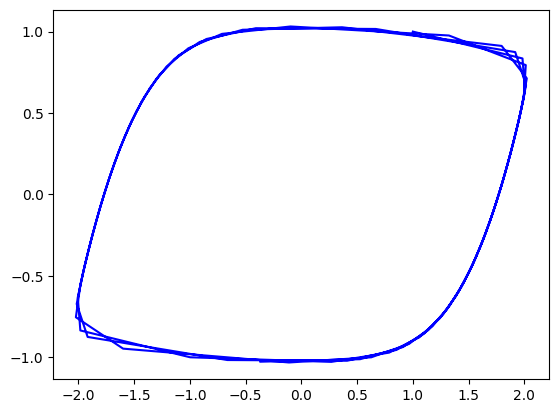

In [34]:
plt.plot(x_real, y_real, 'b-', label='x')

In [35]:
print(len(torch.relu(x_pred_slow - x_ub)))
    

TypeError: relu(): argument 'input' (position 1) must be Tensor, not numpy.ndarray